In [6]:
!unzip -o common-20260127T085735Z-3-001.zip -d .
!ls -al common | head

Archive:  common-20260127T085735Z-3-001.zip
  inflating: ./common/trans_common.csv  
  inflating: ./common/card_common.csv  
  inflating: ./common/user_common.csv  
total 678124
drwxr-xr-x 2 root root      4096 Jan 27 09:18 .
drwxr-xr-x 1 root root      4096 Jan 27 09:18 ..
-rw-r--r-- 1 root root    271929 Jan 25 05:48 card_common.csv
-rw-r--r-- 1 root root 694018664 Jan 25 05:51 trans_common.csv
-rw-r--r-- 1 root root     86669 Jan 25 05:48 user_common.csv


In [7]:
%%bash
unzip -o common-20260127T085735Z-3-001.zip -d .
ls -al common | head

Archive:  common-20260127T085735Z-3-001.zip
  inflating: ./common/trans_common.csv  
  inflating: ./common/card_common.csv  
  inflating: ./common/user_common.csv  
total 678124
drwxr-xr-x 2 root root      4096 Jan 27 09:19 .
drwxr-xr-x 1 root root      4096 Jan 27 09:18 ..
-rw-r--r-- 1 root root    271929 Jan 25 05:48 card_common.csv
-rw-r--r-- 1 root root 694018664 Jan 25 05:51 trans_common.csv
-rw-r--r-- 1 root root     86669 Jan 25 05:48 user_common.csv


In [8]:
!cp common/trans_common.csv trans_common.csv
!cp common/user_common.csv user_common.csv
!cp common/card_common.csv card_common.csv
!ls -al *.csv | head

-rw-r--r-- 1 root root    271929 Jan 27 09:19 card_common.csv
-rw-r--r-- 1 root root 694018664 Jan 27 09:19 trans_common.csv
-rw-r--r-- 1 root root     86669 Jan 27 09:19 user_common.csv


In [9]:
!pip -q install duckdb
import duckdb, os
from IPython.display import display

con = duckdb.connect()
con.execute("PRAGMA threads=4;")

# 파일 존재 확인
for p in ["trans_common.csv","user_common.csv","card_common.csv"]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"파일 없음: {p}")

# common 뷰 생성
con.execute("CREATE OR REPLACE VIEW v_trans_common AS SELECT * FROM read_csv_auto('trans_common.csv');")
con.execute("CREATE OR REPLACE VIEW v_user_common  AS SELECT * FROM read_csv_auto('user_common.csv');")
con.execute("CREATE OR REPLACE VIEW v_card_common  AS SELECT * FROM read_csv_auto('card_common.csv');")

# trans_common 컬럼 확인
cols = set(con.execute("""
SELECT column_name FROM information_schema.columns
WHERE table_name='v_trans_common'
""").fetchdf()["column_name"].tolist())

print("trans_common columns:", sorted(cols))

# amount 컬럼 유연 처리
amt_col = "amount_num" if "amount_num" in cols else ("amount" if "amount" in cols else None)
if amt_col is None:
    raise ValueError("trans_common에 amount_num 또는 amount 컬럼이 없습니다.")

# has_error / error_group 생성(없으면 err_* 더미로 생성)
has_error_expr = "has_error" if "has_error" in cols else \
    ("CASE WHEN (err_card_credential + err_authentication + err_financial + err_system) > 0 THEN 1 ELSE 0 END"
     if {"err_card_credential","err_authentication","err_financial","err_system"}.issubset(cols)
     else "0")

if "error_group" in cols:
    error_group_expr = "error_group"
else:
    if {"err_card_credential","err_authentication","err_financial","err_system"}.issubset(cols):
        error_group_expr = """
        CASE
          WHEN (err_card_credential + err_authentication + err_financial + err_system) = 0 THEN 'NO_ERROR'
          WHEN (err_card_credential + err_authentication) > 0 THEN 'AUTH_CREDENTIAL'
          WHEN err_financial > 0 THEN 'FUNDS'
          WHEN err_system > 0 THEN 'SYSTEM'
          ELSE 'OTHER'
        END
        """
    else:
        error_group_expr = "'NO_ERROR'"

# is_online은 use_chip 기반으로 강제 정의(핵심)
if "use_chip" not in cols:
    raise ValueError("trans_common에 use_chip이 없습니다. is_online 정의 불가.")
is_online_expr = "CASE WHEN use_chip='Online Transaction' THEN 1 ELSE 0 END"

# merchant_id/mcc는 있을 때만 포함 (없으면 NULL)
def pick(col):
    return col if col in cols else "NULL"

con.execute(f"""
CREATE OR REPLACE VIEW v_tx_common AS
SELECT
  CAST(date AS TIMESTAMP) AS date,
  client_id,
  card_id,
  CAST({amt_col} AS DOUBLE) AS amount_num,
  use_chip,
  {is_online_expr} AS is_online,
  {pick("merchant_id")} AS merchant_id,
  {pick("mcc")} AS mcc,
  CAST(fraud AS INTEGER) AS fraud,
  CAST({has_error_expr} AS INTEGER) AS has_error,
  {error_group_expr} AS error_group
FROM v_trans_common
""")

print("[OK] v_tx_common created")
display(con.execute("SELECT COUNT(*) AS n_rows FROM v_tx_common").fetchdf())


trans_common columns: ['amount', 'card_id', 'client_id', 'column00', 'date', 'err_authentication', 'err_card_credential', 'err_financial', 'err_system', 'fraud', 'has_error', 'home_state', 'is_online', 'is_out_of_state', 'mcc', 'merchant_id', 'use_chip']
[OK] v_tx_common created


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows
0,7647524


In [10]:
from IPython.display import display
def q(sql):
    df = con.execute(sql).fetchdf(); display(df); return df

print("1) 행수/기간/사기율")
q("""
SELECT
  COUNT(*) AS n_rows,
  MIN(date) AS min_date,
  MAX(date) AS max_date,
  AVG(CAST(fraud AS DOUBLE)) AS fraud_rate
FROM v_tx_common
""")

print("2) 근사 중복 체크(대체 PK)")
q("""
WITH x AS (
  SELECT
    CONCAT(
      CAST(date AS VARCHAR), '|',
      CAST(client_id AS VARCHAR), '|',
      CAST(card_id AS VARCHAR), '|',
      CAST(merchant_id AS VARCHAR), '|',
      CAST(mcc AS VARCHAR), '|',
      CAST(amount_num AS VARCHAR)
    ) AS approx_key
  FROM v_tx_common
)
SELECT
  (SELECT COUNT(*) FROM v_tx_common) AS n_rows,
  COUNT(DISTINCT approx_key) AS n_distinct_approx_key,
  (SELECT COUNT(*) FROM v_tx_common) - COUNT(DISTINCT approx_key) AS approx_dup_rows
FROM x
""")

print("3) 라벨 분포")
q("""
SELECT CAST(fraud AS INTEGER) AS fraud, COUNT(*) AS n
FROM v_tx_common
GROUP BY 1
ORDER BY 1
""")

print("4) is_online 정합성(강제 정의라 mismatch=0이 정상)")
q("""
WITH x AS (
  SELECT
    is_online,
    CASE WHEN use_chip='Online Transaction' THEN 1 ELSE 0 END AS online_by_use_chip
  FROM v_tx_common
)
SELECT
  AVG(CASE WHEN is_online=online_by_use_chip THEN 1.0 ELSE 0.0 END) AS match_rate,
  SUM(CASE WHEN is_online!=online_by_use_chip THEN 1 ELSE 0 END) AS mismatch_rows,
  COUNT(*) AS total_rows
FROM x
""")

print("5) amount_num 결측/음수/0")
q("""
SELECT
  SUM(CASE WHEN amount_num IS NULL THEN 1 ELSE 0 END) AS null_amt,
  SUM(CASE WHEN amount_num < 0 THEN 1 ELSE 0 END) AS neg_amt,
  SUM(CASE WHEN amount_num = 0 THEN 1 ELSE 0 END) AS zero_amt,
  COUNT(*) AS n_rows
FROM v_tx_common
""")

print("6) has_error / error_group 분포")
q("SELECT has_error, COUNT(*) AS n FROM v_tx_common GROUP BY 1 ORDER BY 1")
q("SELECT error_group, COUNT(*) AS n FROM v_tx_common GROUP BY 1 ORDER BY n DESC")


1) 행수/기간/사기율


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,min_date,max_date,fraud_rate
0,7647524,2010-01-01 00:01:00,2018-06-23 11:13:00,0.001447


2) 근사 중복 체크(대체 PK)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,n_distinct_approx_key,approx_dup_rows
0,7647524,7647480,44


3) 라벨 분포


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,fraud,n
0,0,7636461
1,1,11063


4) is_online 정합성(강제 정의라 mismatch=0이 정상)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,match_rate,mismatch_rows,total_rows
0,1.0,0.0,7647524


5) amount_num 결측/음수/0


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,null_amt,neg_amt,zero_amt,n_rows
0,0.0,380793.0,6208.0,7647524


6) has_error / error_group 분포


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,has_error,n
0,0,7525963
1,1,121561


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,error_group,n
0,NO_ERROR,7525963
1,FUNDS,75373
2,AUTH_CREDENTIAL,30992
3,SYSTEM,15196


,error_group,n
0,NO_ERROR,7525963
1,FUNDS,75373
2,AUTH_CREDENTIAL,30992
3,SYSTEM,15196


In [11]:
from IPython.display import display
def q(sql):
    df = con.execute(sql).fetchdf(); display(df); return df

base = con.execute("SELECT AVG(CAST(fraud AS DOUBLE)) FROM v_tx_common").fetchone()[0]
print("BASE fraud_rate =", base)

q(f"""
WITH base AS (SELECT {base}::DOUBLE AS base_rate)
SELECT is_online, COUNT(*) AS n,
       AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
       AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
FROM v_tx_common, base
GROUP BY 1, base_rate
ORDER BY fraud_rate DESC
""")

q(f"""
WITH base AS (SELECT {base}::DOUBLE AS base_rate)
SELECT has_error, COUNT(*) AS n,
       AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
       AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
FROM v_tx_common, base
GROUP BY 1, base_rate
ORDER BY fraud_rate DESC
""")

q(f"""
WITH base AS (SELECT {base}::DOUBLE AS base_rate)
SELECT error_group, COUNT(*) AS n,
       AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
       AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
FROM v_tx_common, base
GROUP BY 1, base_rate
HAVING COUNT(*) >= 5000
ORDER BY fraud_rate DESC
""")

q(f"""
WITH base AS (SELECT {base}::DOUBLE AS base_rate)
SELECT is_online, error_group, COUNT(*) AS n,
       AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
       AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
FROM v_tx_common, base
GROUP BY 1,2, base_rate
HAVING COUNT(*) >= 5000
ORDER BY fraud_rate DESC
LIMIT 30
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BASE fraud_rate = 0.0014466120014791715


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,is_online,n,fraud_rate,lift
0,1,890771,0.009760,6.746857
1,0,6756753,0.000351,0.242368


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,has_error,n,fraud_rate,lift
0,1,121561,0.003965,2.740947
1,0,7525963,0.001406,0.971880


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,error_group,n,fraud_rate,lift
0,AUTH_CREDENTIAL,30992,0.010067,6.959098
1,FUNDS,75373,0.001910,1.320671
2,SYSTEM,15196,0.001711,1.182747
3,NO_ERROR,7525963,0.001406,0.971880


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,is_online,error_group,n,fraud_rate,lift
0,1,AUTH_CREDENTIAL,11649,0.021890,15.132109
1,1,FUNDS,6913,0.016925,11.699498
2,1,NO_ERROR,870421,0.009540,6.594865
3,0,AUTH_CREDENTIAL,19343,0.002947,2.037037
4,0,SYSTEM,13408,0.000597,0.412452
5,0,FUNDS,68460,0.000394,0.272631
6,0,NO_ERROR,6655542,0.000342,0.236498


,is_online,error_group,n,fraud_rate,lift
0,1,AUTH_CREDENTIAL,11649,0.021890,15.132109
1,1,FUNDS,6913,0.016925,11.699498
2,1,NO_ERROR,870421,0.009540,6.594865
3,0,AUTH_CREDENTIAL,19343,0.002947,2.037037
4,0,SYSTEM,13408,0.000597,0.412452
5,0,FUNDS,68460,0.000394,0.272631
6,0,NO_ERROR,6655542,0.000342,0.236498


**1.  사기는 온라인 채널 중심**

온라인은 평균 대비 약 6.75배의 위험이 있고,

오프라인은 평균의 0.24배로 훨씬 낮음

**2.   오류 존재 자체가 위험 신호 가설 유지**

오류가 있는 거래는 평균 대비 약 2.74배 위험,

오류 없는 거래는 평균 수준

**3. 인증/자격증명 오류(AUTH_CREDENTIAL)가 사기 전조라는 가설도 유지**

오류 중에서도 AUTH_CREDENTIAL이 약 7배의 위험 신호 보냄

**4.Warning System 설계에서 “온라인 + 인증오류”는 최우선 High-risk Rule 후보.**

온라인+인증오류 조합이 평균 대비 15배, fraud_day_rate도 2%로 최상위 위험군

오류의 위험 효과는 온라인에서 훨씬 강하게 증폭

AUTH_CREDENTIAL도 온라인 2,189%, 오프라인 0.295%로 큰 차이 보임





In [12]:
from IPython.display import display

con.execute("""
CREATE OR REPLACE TABLE card_daily_log_common AS
SELECT
  card_id,
  DATE_TRUNC('day', date) AS day,
  COUNT(*) AS tx_cnt,
  SUM(amount_num) AS amt_sum,
  MAX(amount_num) AS amt_max,
  SUM(CASE WHEN is_online=1 THEN 1 ELSE 0 END) AS online_cnt,
  AVG(CASE WHEN is_online=1 THEN 1.0 ELSE 0.0 END) AS online_ratio,
  SUM(CASE WHEN has_error=1 THEN 1 ELSE 0 END) AS error_cnt,
  SUM(CASE WHEN error_group='AUTH_CREDENTIAL' THEN 1 ELSE 0 END) AS auth_cred_err_cnt,
  COUNT(DISTINCT CAST(merchant_id AS BIGINT)) AS uniq_merchant_cnt,
  COUNT(DISTINCT CAST(mcc AS BIGINT)) AS uniq_mcc_cnt
FROM v_tx_common
WHERE amount_num IS NOT NULL
GROUP BY 1,2
""")

display(con.execute("""
SELECT COUNT(*) AS card_days, COUNT(DISTINCT card_id) AS cards
FROM card_daily_log_common
""").fetchdf())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,card_days,cards
0,4617850,3991


거래 단위 데이터를 하루 단위로 바꿔서, 하나의 행에 하루 거래 횟수, 총액, 온라인 비중, 오류, 다양성의 지표를 담음.

카드 수가 충분히 많고,

card-day가 수백만 단위라서

z-score 버킷을 나눠도 표본이 충분하고

fraud_day_rate 같은 것을 안정적으로 추정 가능

In [13]:
from IPython.display import display

con.execute("""
CREATE OR REPLACE TABLE card_daily_features_common AS
WITH base AS (
  SELECT
    *,
    AVG(tx_cnt) OVER w AS tx_cnt_mean_30d,
    STDDEV_SAMP(tx_cnt) OVER w AS tx_cnt_std_30d,
    AVG(amt_sum) OVER w AS amt_sum_mean_30d,
    STDDEV_SAMP(amt_sum) OVER w AS amt_sum_std_30d,
    AVG(online_ratio) OVER w AS online_ratio_mean_30d,
    STDDEV_SAMP(online_ratio) OVER w AS online_ratio_std_30d
  FROM card_daily_log_common
  WINDOW w AS (
    PARTITION BY card_id
    ORDER BY day
    ROWS BETWEEN 30 PRECEDING AND 1 PRECEDING
  )
)
SELECT
  *,
  CASE WHEN amt_sum_std_30d > 0 THEN (amt_sum - amt_sum_mean_30d) / amt_sum_std_30d END AS amt_sum_z_30d
FROM base
""")

display(con.execute("""
SELECT * FROM card_daily_features_common ORDER BY day DESC LIMIT 5
""").fetchdf())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,card_id,day,tx_cnt,amt_sum,amt_max,online_cnt,online_ratio,error_cnt,auth_cred_err_cnt,uniq_merchant_cnt,uniq_mcc_cnt,tx_cnt_mean_30d,tx_cnt_std_30d,amt_sum_mean_30d,amt_sum_std_30d,online_ratio_mean_30d,online_ratio_std_30d,amt_sum_z_30d
0,4303,2018-06-23,2,24.17,20.56,0.0,0.0,0.0,0.0,2,2,1.300000,0.534983,29.933000,28.845776,0.016667,0.091287,-0.199787
1,5505,2018-06-23,1,27.46,27.46,1.0,1.0,0.0,0.0,1,1,1.566667,0.727932,62.633000,71.739086,0.561111,0.453770,-0.490291
2,5852,2018-06-23,1,80.18,80.18,0.0,0.0,0.0,0.0,1,1,1.166667,0.461133,52.689000,152.328458,0.077778,0.257951,0.180472
3,6035,2018-06-23,1,120.00,120.00,0.0,0.0,0.0,0.0,1,1,1.566667,0.626062,178.247000,137.057379,0.016667,0.091287,-0.424983
4,6006,2018-06-23,3,183.27,83.46,0.0,0.0,1.0,0.0,3,2,2.466667,1.591645,105.402667,81.996491,0.022222,0.084569,0.949642


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,bucket,n_days,fraud_days,fraud_day_rate
0,z>=3,128084,1760.0,0.013741
1,2<=z<3,129257,446.0,0.003450
2,1<=z<2,349397,664.0,0.001900
3,z<1,4003128,2124.0,0.000531
4,NA,7984,8.0,0.001002


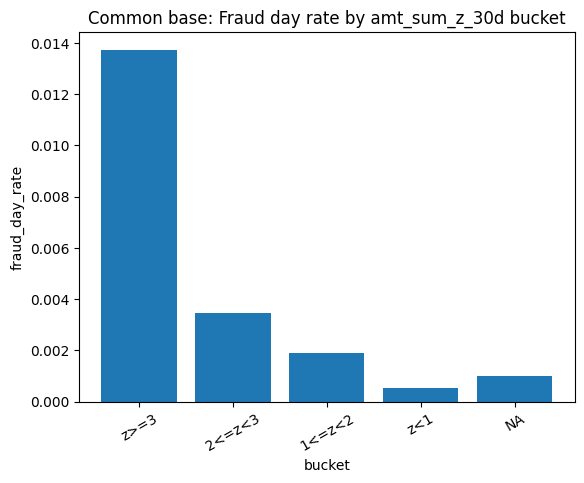

In [14]:
import matplotlib.pyplot as plt
from IPython.display import display

con.execute("""
CREATE OR REPLACE VIEW v_card_day_fraud_common AS
SELECT
  card_id,
  DATE_TRUNC('day', date) AS day,
  MAX(CAST(fraud AS INTEGER)) AS fraud_day
FROM v_tx_common
GROUP BY 1,2
""")

con.execute("""
CREATE OR REPLACE VIEW v_cfinal_common AS
SELECT f.*, COALESCE(d.fraud_day, 0) AS fraud_day
FROM card_daily_features_common f
LEFT JOIN v_card_day_fraud_common d
USING(card_id, day)
""")

df_bucket = con.execute("""
SELECT
  CASE
    WHEN amt_sum_z_30d IS NULL THEN 'NA'
    WHEN amt_sum_z_30d >= 3 THEN 'z>=3'
    WHEN amt_sum_z_30d >= 2 THEN '2<=z<3'
    WHEN amt_sum_z_30d >= 1 THEN '1<=z<2'
    ELSE 'z<1'
  END AS bucket,
  COUNT(*) AS n_days,
  SUM(fraud_day) AS fraud_days,
  AVG(CAST(fraud_day AS DOUBLE)) AS fraud_day_rate
FROM v_cfinal_common
GROUP BY 1
ORDER BY
  CASE bucket
    WHEN 'z>=3' THEN 1
    WHEN '2<=z<3' THEN 2
    WHEN '1<=z<2' THEN 3
    WHEN 'z<1' THEN 4
    ELSE 5
  END
""").fetchdf()

display(df_bucket)

plt.figure()
plt.bar(df_bucket["bucket"], df_bucket["fraud_day_rate"])
plt.title("Common base: Fraud day rate by amt_sum_z_30d bucket")
plt.xlabel("bucket")
plt.ylabel("fraud_day_rate")
plt.xticks(rotation=30)
plt.show()


amt_sum_z_30d는 카드별 ‘하루 총 결제금액(amt_sum)’이 최근 30일 평균 대비 얼마나 급증했는지를 z-score로 나타낸 값

fraud_day_rate는 그 카드-그날에 fraud 거래가 1건이라도 있었던 비율

평소 대비 하루 총액이 3표준편차 이상 급증한 날은, 평소 범위(z<1)인 날보다 사기일 확률이 약 26배 높다.

경고량 관점에서 전체의 2.8%만 경고 대상으로 잡는데도 그 구간의 사기 확률은 1.37%로 높음

따라서 경고를 너무 많이 울리지 않으면서 고위험 구간을 잘 뽑는 지표라고 결론지을수 있음

In [15]:
from IPython.display import display

# 베이스(전체) 값
base_day = con.execute("SELECT AVG(CAST(fraud_day AS DOUBLE)) FROM v_cfinal_common").fetchone()[0]
tot_days = con.execute("SELECT COUNT(*) FROM v_cfinal_common").fetchone()[0]
tot_fraud_days = con.execute("SELECT SUM(fraud_day) FROM v_cfinal_common").fetchone()[0]

print("base_day_rate:", base_day, "| total_days:", tot_days, "| total_fraud_days:", tot_fraud_days)

df_cov = con.execute(f"""
WITH b AS (
  SELECT
    CASE
      WHEN amt_sum_z_30d IS NULL THEN 'NA'
      WHEN amt_sum_z_30d >= 3 THEN 'z>=3'
      WHEN amt_sum_z_30d >= 2 THEN '2<=z<3'
      WHEN amt_sum_z_30d >= 1 THEN '1<=z<2'
      ELSE 'z<1'
    END AS bucket,
    fraud_day
  FROM v_cfinal_common
)
SELECT
  bucket,
  COUNT(*) AS n_days,
  SUM(fraud_day) AS fraud_days,
  AVG(CAST(fraud_day AS DOUBLE)) AS fraud_day_rate,
  COUNT(*) * 1.0 / {tot_days} AS coverage,                 -- 경보량(비율)
  SUM(fraud_day) * 1.0 / {tot_fraud_days} AS fraud_share,  -- 전체 fraud_day 중 커버 비율
  (AVG(CAST(fraud_day AS DOUBLE)) / {base_day}) AS lift_day -- day-level lift
FROM b
GROUP BY 1
ORDER BY
  CASE bucket
    WHEN 'z>=3' THEN 1
    WHEN '2<=z<3' THEN 2
    WHEN '1<=z<2' THEN 3
    WHEN 'z<1' THEN 4
    ELSE 5
  END
""").fetchdf()

display(df_cov)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

base_day_rate: 0.0010831880637093018 | total_days: 4617850 | total_fraud_days: 5002


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,bucket,n_days,fraud_days,fraud_day_rate,coverage,fraud_share,lift_day
0,z>=3,128084,1760.0,0.013741,0.027737,0.351859,12.685685
1,2<=z<3,129257,446.0,0.003450,0.027991,0.089164,3.185495
2,1<=z<2,349397,664.0,0.001900,0.075662,0.132747,1.754466
3,z<1,4003128,2124.0,0.000531,0.866881,0.424630,0.489837
4,NA,7984,8.0,0.001002,0.001729,0.001599,0.925051


# 1) 각 컬럼 뜻

n_days: 해당 버킷에 속한 card-day 개수

fraud_days: 그 중 사기일 개수(fraud_day=1)

fraud_day_rate: fraud_days / n_days (그 버킷의 ‘사기일 확률’)

coverage: n_days / total_days (전체 중 경고가 울리는 비율 = 경보량)

fraud_share: fraud_days / total_fraud_days (전체 사기일 중 얼마를 잡는지 = 커버)

lift_day: fraud_day_rate / base_day_rate (베이스 대비 몇 배 위험)

# 2) 핵심 해석: z>=3는 “효율 좋은 강한 룰”
z>=3 버킷

fraud_day_rate = 0.013741 (1.374%)

coverage = 0.027737 (2.77%)

fraud_share = 0.351859 (35.19%)

lift_day = 12.69배

👉 해석:

전체 card-day의 2.77%만 경고로 잡으면

전체 사기일의 35.2%를 커버함

그 경고군의 사기일 확률이 평균(0.108%) 대비 12.7배 높음

이건 Warning 시스템에서 정말 좋은 형태야:

경보량은 낮고(운영 부담 작음)

사기 커버는 꽤 큼

설명도 쉬움: “최근 30일 대비 총액이 3σ 이상 급증”

# 3) 임계값을 낮추면(2<=z<3까지 포함) 어떻게 되나?

너 표는 버킷별로 따로 보여주고 있으니, “z>=2”처럼 누적 기준으로 보면 더 직관적이야. 하지만 표만으로도 방향은 보임:

2<=z<3 단독

fraud_day_rate 0.345%

coverage 2.80%

fraud_share 8.92%

lift 3.19배

만약 “z>=2 경고”로 누적하면:

coverage는 약 2.77% + 2.80% ≈ 5.6%

fraud_share는 35.19% + 8.92% ≈ 44.1%

👉 해석:

경보량을 2배로 늘리면(2.8% → 5.6%)

커버는 약 9%p 정도 더 늘어난다(35% → 44%)

이건 운영 정책에 따라 선택:

경보 예산이 빡빡하면 z>=3

조금 더 잡고 싶으면 z>=2

# 4) z<1은 “저위험 대규모 정상군”

coverage 86.69%로 대부분이 여기에 속함

fraud_share 42.46%로, 사기일도 절대 수로는 많이 포함됨(모수가 크니까)

하지만 fraud_day_rate 0.053%로 낮고 lift도 0.49배

👉 해석:

이 구간은 경고를 울리기엔 비효율적(오탐이 많아짐)

대신 “기본 통과/저위험군”으로 두고,

다른 강한 신호(온라인+인증오류 등)가 있을 때만 경고를 고려하는 게 합리적.

# 5) NA는 신경 쓸 필요 거의 없음

coverage 0.17%

fraud_share 0.16%

lift 0.93배

👉 해석:

기준선 부족 구간이라 별도 처리할 수 있지만, 영향이 작음.

+amt_sum_z_30d >= 3 룰을 적용하면 전체 card-day의 2.77%만 경고로 잡으면서 사기일의 35.2%를 커버하고, 해당 경고군의 사기일 확률은 평균 대비 12.7배 높다